# Time Series Dataset Creation

c:\Users\pierr\anaconda3\envs\research\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


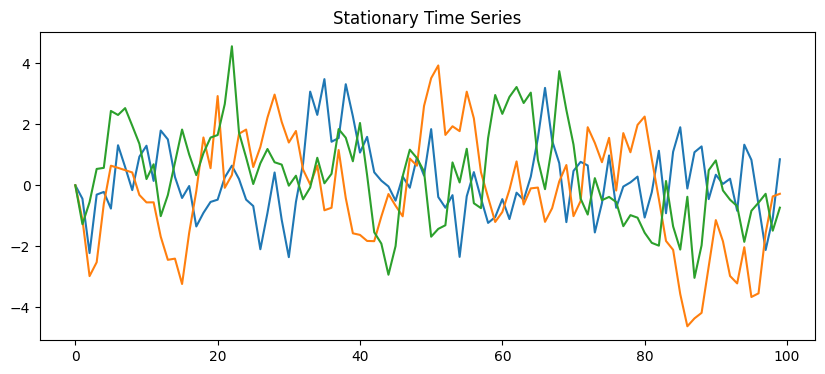

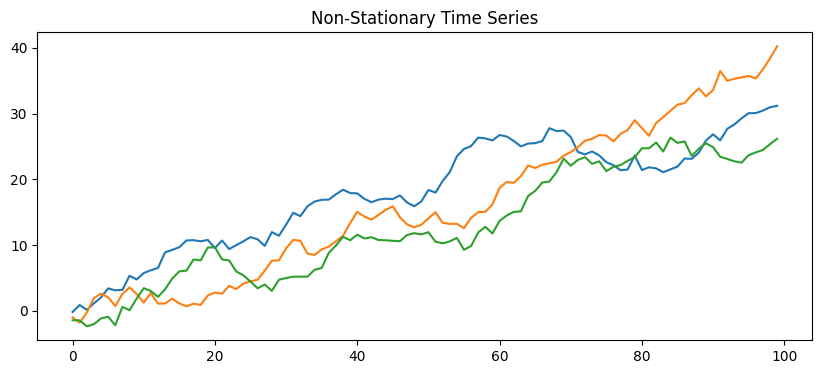

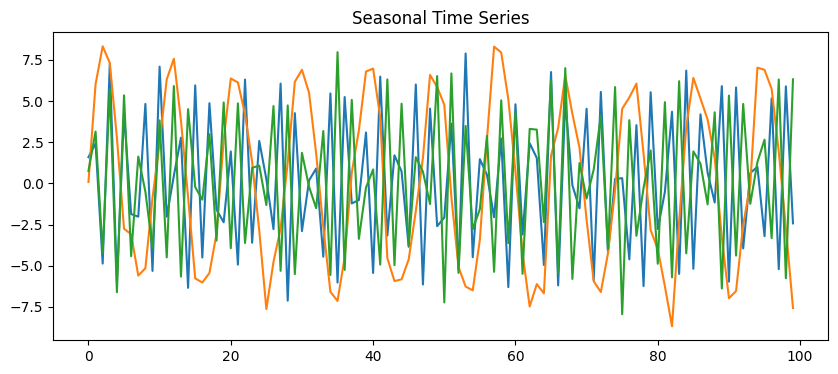

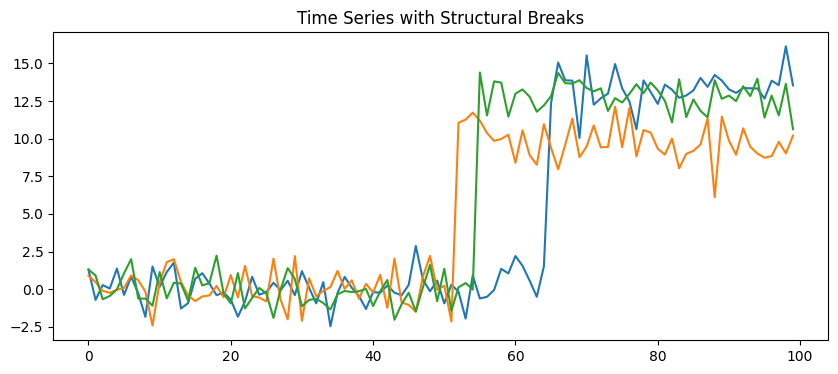

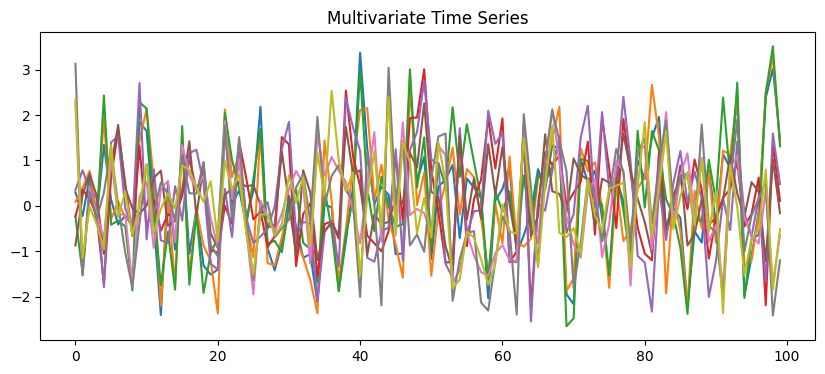

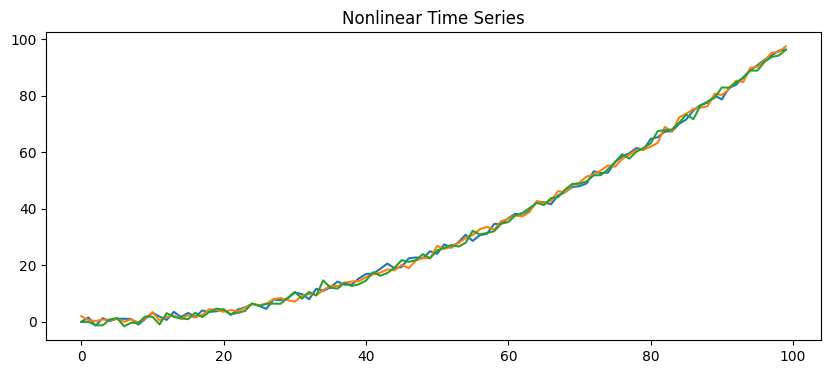

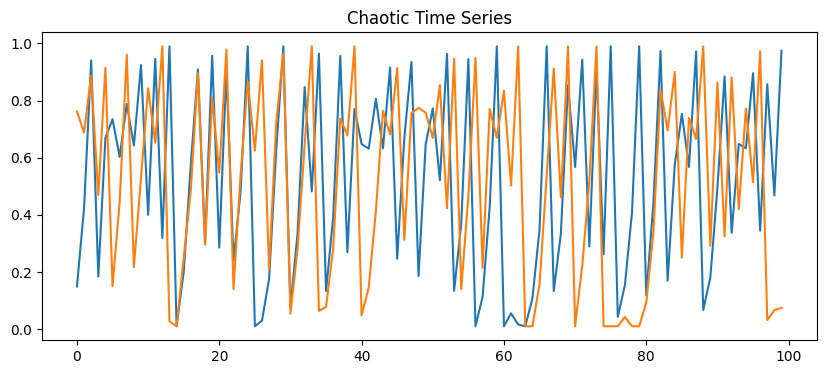

In [1]:
import numpy as np
import tsgm
from tensorflow import keras
import matplotlib.pyplot as plt

# Define parameters
seq_len = 100
feature_dim = 1
latent_dim = 10
N_EPOCHS = 1000

# Helper function to plot datasets
def plot_dataset(dataset, title):
    plt.figure(figsize=(10, 4))
    for i in range(min(len(dataset), 3)):  # Plot the first 3 series
        plt.plot(dataset[i])
    plt.title(title)
    plt.show()

# 1. Stationary Time Series (AR(1) Processes)
stationary_datasets = []
for i in range(5):
    ar_coeff = np.random.uniform(0.5, 0.9)
    noise = np.random.normal(0, 1, seq_len)
    series = np.zeros(seq_len)
    for t in range(1, seq_len):
        series[t] = ar_coeff * series[t-1] + noise[t]
    stationary_datasets.append(series.reshape(-1, 1))

plot_dataset(stationary_datasets, "Stationary Time Series")

# 2. Non-Stationary Time Series (Random Walks and Trends)
non_stationary_datasets = []
for i in range(5):
    steps = np.random.normal(0, 1, seq_len)
    trend = np.random.uniform(0.1, 0.5)
    series = np.cumsum(steps) + trend * np.arange(seq_len)
    non_stationary_datasets.append(series.reshape(-1, 1))

plot_dataset(non_stationary_datasets, "Non-Stationary Time Series")

# 3. Seasonal Time Series (Sine Waves with Noise)
seasonal_datasets = []
for i in range(5):
    freq = np.random.uniform(0.1, 0.5)
    amplitude = np.random.uniform(5, 10)
    noise = np.random.normal(0, 1, seq_len)
    series = amplitude * np.sin(2 * np.pi * freq * np.arange(seq_len)) + noise
    seasonal_datasets.append(series.reshape(-1, 1))

plot_dataset(seasonal_datasets, "Seasonal Time Series")

# 4. Time Series with Structural Breaks
structural_break_datasets = []
for i in range(5):
    breakpoint = np.random.randint(seq_len // 4, 3 * seq_len // 4)
    series = np.random.normal(0, 1, seq_len)
    series[breakpoint:] += np.random.uniform(5, 15)
    structural_break_datasets.append(series.reshape(-1, 1))

plot_dataset(structural_break_datasets, "Time Series with Structural Breaks")

# 5. Multivariate Time Series
multivariate_datasets = []
for i in range(3):
    base_series = np.random.normal(0, 1, seq_len)
    related_series_1 = base_series + np.random.normal(0, 0.5, seq_len)
    related_series_2 = base_series * np.random.uniform(0.5, 1.5) + np.random.normal(0, 0.5, seq_len)
    dataset = np.stack([base_series, related_series_1, related_series_2], axis=1)
    multivariate_datasets.append(dataset)

plot_dataset(multivariate_datasets, "Multivariate Time Series")

# 6. Nonlinear Time Series
nonlinear_datasets = []
for i in range(3):
    series = 0.01 * np.square(np.arange(seq_len)) + np.random.normal(0, 1, seq_len)
    nonlinear_datasets.append(series.reshape(-1, 1))

plot_dataset(nonlinear_datasets, "Nonlinear Time Series")

# 7. Chaotic Time Series
chaotic_datasets = []
for i in range(2):
    series = np.zeros(seq_len)
    series[0] = np.random.uniform(0.1, 0.9)
    for t in range(1, seq_len):
        series[t] = 3.8 * series[t-1] * (1 - series[t-1]) + np.random.normal(0, 0.1)
        # Clamp the value to avoid overflow
        series[t] = np.clip(series[t], 0.01, 0.99)
    chaotic_datasets.append(series.reshape(-1, 1))

plot_dataset(chaotic_datasets, "Chaotic Time Series")


# Now we have 28 datasets ready for further processing

# DPMM with SSM

In [5]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Use the structural_break_datasets created earlier
dataset = np.array(structural_break_datasets).reshape(len(structural_break_datasets), -1)

# Define the DPMM with SSM in PyMC
with pm.Model() as dpmm_ssm_model:
    # Dirichlet Process concentration parameter (controls number of clusters)
    alpha = pm.Gamma('alpha', 1.0, 1.0)

    # Stick-breaking process for the mixture weights
    beta = pm.Beta('beta', 1, alpha, shape=dataset.shape[0])
    
    # Cumulative product for stick-breaking
    stick_segment = pm.math.cumprod(1 - beta)
    
    # Combine to get weights
    w = pm.Deterministic('w', beta * pm.math.concatenate([[1], stick_segment[:-1]]))

    # Priors for the SSM parameters for each cluster
    A = pm.Normal('A', mu=1.0, sigma=1.0, shape=dataset.shape[0])  # State transition matrices for each cluster
    Q = pm.Exponential('Q', 1.0, shape=dataset.shape[0])  # Process noise covariance for each cluster
    R = pm.Exponential('R', 1.0, shape=dataset.shape[0])  # Observation noise covariance for each cluster
    
    # Cluster assignment for each time series
    cluster_assignments = pm.Categorical('cluster_assignments', p=w, shape=dataset.shape[0])

    # Define the state space model for each time series based on cluster assignments
    h = []
    for n in range(dataset.shape[0]):
        # Get the cluster assignment for the nth time series
        cluster = cluster_assignments[n]

        # Define the hidden states based on the cluster's parameters
        h_n = pm.Normal(f'h_{n}', mu=A[cluster] * np.zeros(dataset.shape[1]), sigma=np.sqrt(Q[cluster]), shape=dataset.shape[1])

        # Observation model
        pm.Normal(f'y_obs_{n}', mu=h_n, sigma=np.sqrt(R[cluster]), observed=dataset[n])

    # Perform Variational Inference or MCMC
    trace = pm.sample(1000, tune=2000)

# Analyze the results
pm.plot_trace(trace)
plt.show()

# Summary of the trace
print(pm.summary(trace))


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(0.), 'beta_logodds__': array([0., 0., 0., 0., 0.]), 'A': array([1., 1., 1., 1., 1.]), 'Q_log__': array([0., 0., 0., 0., 0.]), 'R_log__': array([0., 0., 0., 0., 0.]), 'cluster_assignments': array([0, 0, 0, 0, 0], dtype=int64), 'h_0': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'h_1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'h_2': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'h_3': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'h_4': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

Logp initial evaluation results:
{'alpha': -1.0, 'beta': -6.93, 'A': -4.59, 'Q': -5.0, 'R': -5.0, 'cluster_assignments': -inf, 'h_0': -91.89, 'h_1': -91.89, 'h_2': -91.89, 'h_3': -91.89, 'h_4': -91.89, 'y_obs_0': -3255.83, 'y_obs_1': -2457.39, 'y_obs_2': -3831.65, 'y_obs_3': -1353.06, 'y_obs_4': -3103.1}
You can call `model.debug()` for more details.

In [6]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Use the structural_break_datasets created earlier
dataset = np.array(structural_break_datasets).reshape(len(structural_break_datasets), -1)

# Define the DPMM with SSM in PyMC
with pm.Model() as dpmm_ssm_model:
    # Dirichlet Process concentration parameter (controls number of clusters)
    alpha = pm.Gamma('alpha', 1.0, 1.0)

    # Stick-breaking process for the mixture weights
    beta = pm.Beta('beta', 1, alpha, shape=dataset.shape[0])
    stick_segment = pm.math.cumprod(1 - beta)
    w = pm.Deterministic('w', beta * pm.math.concatenate([[1], stick_segment[:-1]]))
    
    # Normalize weights to ensure they sum to 1
    w = w / pm.math.sum(w)
    
    # Priors for the SSM parameters for each cluster
    A = pm.Normal('A', mu=1.0, sigma=1.0, shape=dataset.shape[0])  # State transition matrices for each cluster
    Q = pm.Exponential('Q', 1.0, shape=dataset.shape[0])  # Process noise covariance for each cluster
    R = pm.Exponential('R', 1.0, shape=dataset.shape[0])  # Observation noise covariance for each cluster
    
    # Cluster assignment for each time series
    cluster_assignments = pm.Categorical('cluster_assignments', p=w, shape=dataset.shape[0])

    # Define the state space model for each time series based on cluster assignments
    for n in range(dataset.shape[0]):
        # Get the cluster assignment for the nth time series
        cluster = cluster_assignments[n]

        # Define the hidden states based on the cluster's parameters
        h_n = pm.Normal(f'h_{n}', mu=A[cluster] * 0.0, sigma=np.sqrt(Q[cluster]), shape=dataset.shape[1])

        # Observation model
        pm.Normal(f'y_obs_{n}', mu=h_n, sigma=np.sqrt(R[cluster]), observed=dataset[n])

    # Perform Variational Inference or MCMC
    trace = pm.sample(1000, tune=2000)

# Analyze the results
pm.plot_trace(trace)
plt.show()

# Summary of the trace
print(pm.summary(trace))


c:\Users\pierr\anaconda3\envs\research\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.